# Chapter 3
## MNIST Dataset
That's right! It downloads to $HOME/scikit_learn_data

In [1]:
from sklearn.datasets import fetch_mldata
try:
    mnist = fetch_mldata('MNIST original')
except Exception as ex:        
    from six.moves import urllib
    from scipy.io import loadmat
    import os

    mnist_path = os.path.join(".", "datasets", "mnist-original.mat")

    # download dataset from github.
    mnist_alternative_url = "https://github.com/amplab/datascience-sp14/raw/master/lab7/mldata/mnist-original.mat"
    response = urllib.request.urlopen(mnist_alternative_url)
    with open(mnist_path, "wb") as f:
        content = response.read()
        f.write(content)

    mnist_raw = loadmat(mnist_path)
    mnist = {
        "data": mnist_raw["data"].T,
        "target": mnist_raw["label"][0],
        "COL_NAMES": ["label", "data"],
        "DESCR": "mldata.org dataset: mnist-original",
    }
    print("Done!")

Let's give the dataset a quick shakedown...

In [2]:
X, y = mnist["data"], mnist["target"]
print(X.shape)
print(y.shape)

(70000, 784)
(70000,)


In this dataset there are 70,000 images with 784 features, the 784 comming from a 28x28 grayscale picture. Let's take a look, shall we?

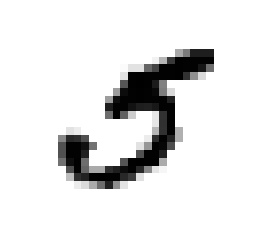

In [3]:
%matplotlib inline
import matplotlib
import matplotlib.pyplot as plt

some_digit = X[36000]
some_digit_image = some_digit.reshape(28, 28)
plt.imshow(some_digit_image, cmap=matplotlib.cm.binary,
          interpolation="nearest")
plt.axis("off")
plt.show()

And for a quick of the label to verify...

In [4]:
y[36000]

5.0

Before we go any further, we need to split our training and test data! Luckly for us it's already split!

In [5]:
X_train, X_test, y_train, y_test = X[:60000], X[60000:], y[:60000], y[60000:]

One thing that is definatly a must is to shuffle our data! Some models are particualrly sensitive to repeated numbers!

In [6]:
import numpy as np

shuffle_index = np.random.permutation(60000)
print(shuffle_index)
X_train, y_train = X_train[shuffle_index], y_train[shuffle_index]

[59733 47160 57173 ... 47062 15213 28558]


## Training a Binary Classifer
For our first task we will practice making a Classifer that determines if the number is 5 or if it's not 5.

Let's begin by making the target vector

In [7]:
y_train_5 = (y_train == 5)
y_test_5 = (y_test == 5)

Cools, now we'll pick a classifier, _Stochastic Gradient Decesnt_(SDG) in this case using Scikit's `SGDClassifier` class. Because this class handles training instances independantly, it's well suited for online learning.

In [8]:
from sklearn.linear_model import SGDClassifier

sgd_clf = SGDClassifier(random_state=42)
sgd_clf.fit(X_train, y_train_5)

/home/marflo356/.local/share/virtualenvs/ML-Practice-JQdyjNbZ/lib/python3.6/site-packages/sklearn/linear_model/stochastic_gradient.py:128: FutureWarning: max_iter and tol parameters have been added in <class 'sklearn.linear_model.stochastic_gradient.SGDClassifier'> in 0.19. If both are left unset, they default to max_iter=5 and tol=None. If tol is not None, max_iter defaults to max_iter=1000. From 0.21, default max_iter will be 1000, and default tol will be 1e-3.
  "and default tol will be 1e-3." % type(self), FutureWarning)


SGDClassifier(alpha=0.0001, average=False, class_weight=None, epsilon=0.1,
       eta0=0.0, fit_intercept=True, l1_ratio=0.15,
       learning_rate='optimal', loss='hinge', max_iter=None, n_iter=None,
       n_jobs=1, penalty='l2', power_t=0.5, random_state=42, shuffle=True,
       tol=None, verbose=0, warm_start=False)

Now we can detect images of the nubmer 5!

In [9]:
sgd_clf.predict([some_digit])

array([False])

## Performance Measures
That's right! We made a classifier, so now we have to measure it's performance!

As a quick note, if you ever need to implement CV on your own, you can use this code that does roughly the same as the built in one! Here's an example of what roughly `cross_val_score()` will do on our next bit of code.
```python
from sklearn.model_selection import StratifiedKFold
from sklearn.base import clone

skfolds = StratifiedKFold(n_splits=3, random_state=42)

for train_index, test_index in skfolds.split(X_train, y_train_5):
    clone_clf = clone(sgd_clf)
    X_train_folds = X_train[train_index]
    y_train_folds = (y_train_5[train_index])
    X_test_fold = X_train[test_index]
    y_test_fold = (y_train_5[test_index])
    
    clone_clf.fit(X_train_folds, y_train_folds)
    y_pred = clone_clf.predict(X_test_fold)
    n_correct = sum(y_pred == y_test_fold)
    print(n_correct / len(y_pred))
```

Anywho, for now, let's use `cross_val_score()` to evaluate our `SGDClassifier` using K-fold cross-validation.

In [10]:
from sklearn.model_selection import cross_val_score

cross_val_score(sgd_clf, X_train, y_train_5, cv=3, scoring="accuracy")

/home/marflo356/.local/share/virtualenvs/ML-Practice-JQdyjNbZ/lib/python3.6/site-packages/sklearn/linear_model/stochastic_gradient.py:128: FutureWarning: max_iter and tol parameters have been added in <class 'sklearn.linear_model.stochastic_gradient.SGDClassifier'> in 0.19. If both are left unset, they default to max_iter=5 and tol=None. If tol is not None, max_iter defaults to max_iter=1000. From 0.21, default max_iter will be 1000, and default tol will be 1e-3.
  "and default tol will be 1e-3." % type(self), FutureWarning)
/home/marflo356/.local/share/virtualenvs/ML-Practice-JQdyjNbZ/lib/python3.6/site-packages/sklearn/linear_model/stochastic_gradient.py:128: FutureWarning: max_iter and tol parameters have been added in <class 'sklearn.linear_model.stochastic_gradient.SGDClassifier'> in 0.19. If both are left unset, they default to max_iter=5 and tol=None. If tol is not None, max_iter defaults to max_iter=1000. From 0.21, default max_iter will be 1000, and default tol will be 1e-3.
 

array([0.9633 , 0.96385, 0.9647 ])

Sweet! It looks like we're doing pretty freaking awesome! Before we get too pumped up, let's take a look at a very dumb classifier, one that just classifies every image in the "not-5" class

In [11]:
from sklearn.base import BaseEstimator

class Never5Classifier(BaseEstimator):
    def fit(self, X, y=None):
        pass
    
    
    def predict(self, X):
        return np.zeros((len(X), 1), dtype=bool)

Can you guess the model's accuracy? Let's find out!

In [12]:
never_5_clf = Never5Classifier()
cross_val_score(never_5_clf, X_train, y_train_5, cv=3, scoring="accuracy")

array([0.91075, 0.9095 , 0.9087 ])

This is why accuracy is not a prefered metric for classifers, esspecially when dealing with _skewed datasets_! A better performance measure is to look at the confusion matrix! This is calculated by counting the number of times classes are confused with other classes (ie. 5's with 3's).

First we need something to compare it too. The test set? **NO!** That is **ONLY** for the end of the project! Use CV first!

In [45]:
from sklearn.model_selection import cross_val_predict

y_train_pred = cross_val_predict(sgd_clf, X_train, y_train_5, cv=3)
print(y_train_5.shape)
print(y_train_pred.shape)

/home/marflo356/.local/share/virtualenvs/ML-Practice-JQdyjNbZ/lib/python3.6/site-packages/sklearn/linear_model/stochastic_gradient.py:128: FutureWarning: max_iter and tol parameters have been added in <class 'sklearn.linear_model.stochastic_gradient.SGDClassifier'> in 0.19. If both are left unset, they default to max_iter=5 and tol=None. If tol is not None, max_iter defaults to max_iter=1000. From 0.21, default max_iter will be 1000, and default tol will be 1e-3.
  "and default tol will be 1e-3." % type(self), FutureWarning)
/home/marflo356/.local/share/virtualenvs/ML-Practice-JQdyjNbZ/lib/python3.6/site-packages/sklearn/linear_model/stochastic_gradient.py:128: FutureWarning: max_iter and tol parameters have been added in <class 'sklearn.linear_model.stochastic_gradient.SGDClassifier'> in 0.19. If both are left unset, they default to max_iter=5 and tol=None. If tol is not None, max_iter defaults to max_iter=1000. From 0.21, default max_iter will be 1000, and default tol will be 1e-3.
 

(60000,)
(60000,)


Now we can generate the confusion matrix!

In [14]:
from sklearn.metrics import confusion_matrix

confusion_matrix(y_train_5, y_train_pred)

array([[53534,  1045],
       [ 1118,  4303]])

Here, each row represents an _actual class_ while the column represents a _predicted class_. The first row represents non-5's. Here 53870 were correct, and 709 were incorrect. As for the 5's row, 1381 were wrongly classified while 4040 were correcly classifed.

This gives you a lot of information, but you may prefer a more consise metric. One such metric is to look at the accuracy of the positive predictions. This is call the _precision_ of a classifier

P = TP/(TP+FP)

TP = True Positives
FP = False Positives

This is however can be cheated very easily... make one prediction that's possitve and you have perfect accuracy. 1/1 = 100%. So, to combat this we use _recall_, also called _sensitivity_ or _true positive rate_(_TPR_).

R = TP/(TP+FN)

FN = False Negatives


Scikit also provides functions to calculate these metrics! Let's check it out!

In [15]:
from sklearn.metrics import precision_score, recall_score

print("Precision Score: ", precision_score(y_train_5, y_train_pred))
print("Recall Score: ", recall_score(y_train_5, y_train_pred))

Precision Score:  0.8045998504113687
Recall Score:  0.7937649880095923


Doesn't look as hot as before, does it?

Often, it's much more convinient to combine the metrics into what's called the _F₁ score_ especially if you want to compare two classifiers. This score is the _harmonic mean_ of precision and recall. This gives more weight to low values, so to get a high score, recall and precision must be high.

F₁ = 2/(1/P)+(1/R) = TP/(TP+((FN+FP)/2))

Once again Scikit provides a function for this!

In [16]:
from sklearn.metrics import f1_score

f1_score(y_train_5, y_train_pred)

0.7991456959791996

Keep in mind, this favors classifers with similar precision and recall. You might not always need both though. You may only care about precision in some cases (Keep sfw videos only, high pres but possibly low recall) or high recall in some cases (Detect shop lifters, more FP but almost all shoplifters will get caught!) Unfortunatly, you can't have it all... this is called _precision/recall tradeoff_.

To understand the tradeoff, let's look at how the `SGDClassifier` makes it's classifications. For each instance, it computes a score based on a _decision function_. If that score is greater than a threshold it assigns it a possitive class, else negative.

Since Scikit can't let you choose it's threshold, you can use the classifiers `decision_function()` to make predicitions

In [17]:
y_scores = sgd_clf.decision_function([some_digit])
print(y_scores)

threshold = 0
y_some_digit_pred = (y_scores > threshold)
print(y_some_digit_pred)

[-74785.66657964]
[False]


The `SGDClassifier` uses a threshold of 0, so let's try a different one...

In [18]:
threshold = 20000

y_some_digit_pred = (y_scores > threshold)
print(y_some_digit_pred)

[False]


This comfirms that increasing the threshold decreases recall (while decreaseing precission)! But how can we decide what threshold to use?

First get the score of all instances in the training set using `cross_val_predict()`, but this time specifing you want it to return decision scores instead.

In [19]:
y_scores = cross_val_predict(sgd_clf, X_train, y_train_5, cv=3, method="decision_function")

/home/marflo356/.local/share/virtualenvs/ML-Practice-JQdyjNbZ/lib/python3.6/site-packages/sklearn/linear_model/stochastic_gradient.py:128: FutureWarning: max_iter and tol parameters have been added in <class 'sklearn.linear_model.stochastic_gradient.SGDClassifier'> in 0.19. If both are left unset, they default to max_iter=5 and tol=None. If tol is not None, max_iter defaults to max_iter=1000. From 0.21, default max_iter will be 1000, and default tol will be 1e-3.
  "and default tol will be 1e-3." % type(self), FutureWarning)
/home/marflo356/.local/share/virtualenvs/ML-Practice-JQdyjNbZ/lib/python3.6/site-packages/sklearn/linear_model/stochastic_gradient.py:128: FutureWarning: max_iter and tol parameters have been added in <class 'sklearn.linear_model.stochastic_gradient.SGDClassifier'> in 0.19. If both are left unset, they default to max_iter=5 and tol=None. If tol is not None, max_iter defaults to max_iter=1000. From 0.21, default max_iter will be 1000, and default tol will be 1e-3.
 

Now use this score to compute precisin and recall for all possible threshholds using `precision_recall_curve()`

In [20]:
from sklearn.metrics import precision_recall_curve

precisions, recalls, thresholds = precision_recall_curve(y_train_5, y_scores)

Finally, we can plot it!

<function matplotlib.pyplot.show(*args, **kw)>

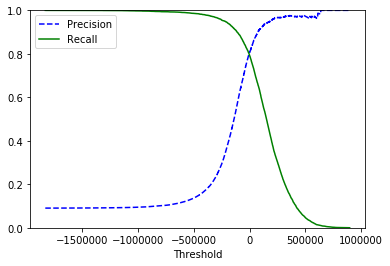

In [21]:
def plot_precision_recall_vs_threshold(precisions, recalls, thresholds):
    plt.plot(thresholds, precisions[:-1], "b--", label="Precision")
    plt.plot(thresholds, recalls[:-1], "g-", label="Recall")
    plt.xlabel("Threshold")
    plt.legend(loc="upper left")
    plt.ylim([0, 1])
    
plot_precision_recall_vs_threshold(precisions, recalls, thresholds)
plt.show

Cool stuff! Let's see what happens when we go for about 90% precision!

In [22]:
y_train_pred_90 = (y_scores > 70000)

And a quick check...

In [23]:
print("Precision: ", precision_score(y_train_5, y_train_pred_90))
print("Recall: ", recall_score(y_train_5, y_train_pred_90))

Precision:  0.8943731490621916
Recall:  0.6685113447703376


Now if someone says "Let's reach 99% accuracy!", say "But at what recall!!!"

Anywho, the _receiver operating characteristic_ (ROC) curve is another common tool for binary classifiers. It plots the _true positive rate_ (another name for recall) against the _false positive rate_. The FPR is a ratio of negative instances against instances that are wrongly labeled positive. FPR is equal to 1 minus the _true negative rate_. TNR is also called _specificity_.

To compute the ROC curve, compute the TPR and FPR for various threshold values using the `roc_curve()` function.

In [24]:
from sklearn.metrics import roc_curve

fpr, tpr, threshold = roc_curve(y_train_5, y_scores)

Then, you can plot FPR against TPR!

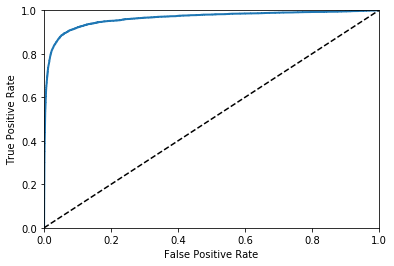

In [25]:
def plot_roc_curve(fpr, tpr, label=None):
    plt.plot(fpr, tpr, linewidth=2, label=label)
    plt.plot([0, 1], [0, 1], 'k--')
    plt.axis([0, 1, 0, 1])
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    
plot_roc_curve(fpr, tpr)
plt.show()

Once again, there is a trade off, the higher the recall (TPR), the more false possitives (FPR) the classifer produces.

A way to compare classifiers are to measeure the _area under the curve_ (AUC). A perfect classifer will have a ROC AUC equal to 1, while a random one will have a ROC AUC of 0.5.

Scikit provide a function for this.

In [26]:
from sklearn.metrics import roc_auc_score

print("ROC AUC: ", roc_auc_score(y_train_5, y_scores))

ROC AUC:  0.9636934030820998


Let's train a `RandomForestClasifier` and compare its ROC curve and ROC AUC score to the SGDClassifier!

First you need to get scores for each instance in the train set. Note that the `RandomForestClassifier` does not have a `decision_function()`, rather a `dict_proba()` method. Scikit-Learn classifiers typically have one or the other.

In [27]:
from sklearn.ensemble import RandomForestClassifier

forest_clf = RandomForestClassifier(random_state=42)
y_probas_forest = cross_val_predict(forest_clf, X_train, y_train_5, cv=3,
                                   method="predict_proba")

But to plot the ROC curve, you need scores, not probabilites! A simple socution is to use the positive class's probability as the score!

In [28]:
y_scores_forest = y_probas_forest[:, 1]  # score = proba of posotive class
fpr_forest, tpr_forest, thresholds_forest = roc_curve(y_train_5, y_scores_forest)

Now you can plot the ROC curve!

/home/marflo356/.local/share/virtualenvs/ML-Practice-JQdyjNbZ/lib/python3.6/site-packages/matplotlib/legend.py:641: UserWarning: Unrecognized location "bottom right". Falling back on "best"; valid locations are
	best
	upper right
	upper left
	lower left
	lower right
	right
	center left
	center right
	lower center
	upper center
	center

  % (loc, '\n\t'.join(self.codes)))


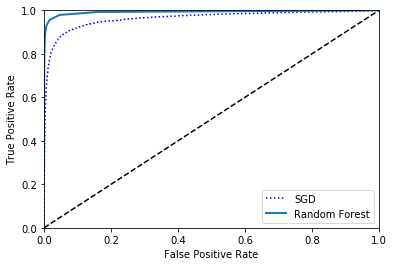

In [29]:
plt.plot(fpr, tpr, "b:", label="SGD")
plot_roc_curve(fpr_forest, tpr_forest, "Random Forest")
plt.legend(loc="bottom right")
plt.show()

Wow! The `RandomForestClassifier`'s ROC curve looks much better than the `SGDClassifier`'s! Let's look at the ROC AUC score...

In [30]:
roc_auc_score(y_train_5, y_scores_forest)

0.9927965047975235

## Mulitclass Classification

Now that we got this done, let's try to detect something more than just 5's! Here, we're going to work with _mulitclass classifiers_ (also called _multinomial classifiers_). Some aglorithms can handle mulitple classes directly. Other are strictly binary classifers using strategies to perform mulitclass classification.

One such method is _one-versus-all_ (OvA) strategy (also called _one-versus-the-rest_). It's where you have a classifer for each class (1-detector, 2-detector, etc.).

Another method is _one-versus-one_ (OvO). This distingishes between 0s and 1s, 0s and 2s, 1s and 2s and so forth. If there are N classes, you're going to need N * (N -1) / 2 classifiers. The main advantage of OvO is that each classifier only need to be trained on the part of training set for the two classes it must distinguish.

Some algorithms (Support Vector Machines) scale poorly with the size of the training set, so OvO is preferred in these cases since it is faster to train many classifiers on small sets than few on large sets. For most applications, OvA is prefered.

Scikit detects when you use a binary for a mulit-class classification task, and uses OvA. Let's try this with `SGDClassifier`

In [31]:
sgd_clf.fit(X_train, y_train)  # y_train not y_train_5
sgd_clf.predict([some_digit])

/home/marflo356/.local/share/virtualenvs/ML-Practice-JQdyjNbZ/lib/python3.6/site-packages/sklearn/linear_model/stochastic_gradient.py:128: FutureWarning: max_iter and tol parameters have been added in <class 'sklearn.linear_model.stochastic_gradient.SGDClassifier'> in 0.19. If both are left unset, they default to max_iter=5 and tol=None. If tol is not None, max_iter defaults to max_iter=1000. From 0.21, default max_iter will be 1000, and default tol will be 1e-3.
  "and default tol will be 1e-3." % type(self), FutureWarning)


array([0.])

Let's check that it actually used 10 classifiers...

In [32]:
some_digit_scores = sgd_clf.decision_function([some_digit])
print("Scores: ", some_digit_scores)

Scores:  [[  40798.7864321  -421646.91868255 -320192.58261413  -47080.31130752
  -448994.70786781  -74785.66657964 -751089.88368326 -470228.27804191
  -775000.69930153 -616853.38118585]]


Let's check it's right...

In [33]:
print("Index: ", np.argmax(some_digit_scores))
print("Classes: ", sgd_clf.classes_)

Index:  0
Classes:  [0. 1. 2. 3. 4. 5. 6. 7. 8. 9.]


If you want Scikit to use OvO or OvA, you can use `OneVsOneClassifier` or `OneVsRestClassifier`.

In [34]:
from sklearn.multiclass import OneVsOneClassifier

ovo_clf = OneVsOneClassifier(SGDClassifier(random_state=42))
ovo_clf.fit(X_train, y_train)
print("Prediction: ", ovo_clf.predict([some_digit]))
print("Num Estimators: ", len(ovo_clf.estimators_))

/home/marflo356/.local/share/virtualenvs/ML-Practice-JQdyjNbZ/lib/python3.6/site-packages/sklearn/linear_model/stochastic_gradient.py:128: FutureWarning: max_iter and tol parameters have been added in <class 'sklearn.linear_model.stochastic_gradient.SGDClassifier'> in 0.19. If both are left unset, they default to max_iter=5 and tol=None. If tol is not None, max_iter defaults to max_iter=1000. From 0.21, default max_iter will be 1000, and default tol will be 1e-3.
  "and default tol will be 1e-3." % type(self), FutureWarning)
/home/marflo356/.local/share/virtualenvs/ML-Practice-JQdyjNbZ/lib/python3.6/site-packages/sklearn/linear_model/stochastic_gradient.py:128: FutureWarning: max_iter and tol parameters have been added in <class 'sklearn.linear_model.stochastic_gradient.SGDClassifier'> in 0.19. If both are left unset, they default to max_iter=5 and tol=None. If tol is not None, max_iter defaults to max_iter=1000. From 0.21, default max_iter will be 1000, and default tol will be 1e-3.
 

/home/marflo356/.local/share/virtualenvs/ML-Practice-JQdyjNbZ/lib/python3.6/site-packages/sklearn/linear_model/stochastic_gradient.py:128: FutureWarning: max_iter and tol parameters have been added in <class 'sklearn.linear_model.stochastic_gradient.SGDClassifier'> in 0.19. If both are left unset, they default to max_iter=5 and tol=None. If tol is not None, max_iter defaults to max_iter=1000. From 0.21, default max_iter will be 1000, and default tol will be 1e-3.
  "and default tol will be 1e-3." % type(self), FutureWarning)
/home/marflo356/.local/share/virtualenvs/ML-Practice-JQdyjNbZ/lib/python3.6/site-packages/sklearn/linear_model/stochastic_gradient.py:128: FutureWarning: max_iter and tol parameters have been added in <class 'sklearn.linear_model.stochastic_gradient.SGDClassifier'> in 0.19. If both are left unset, they default to max_iter=5 and tol=None. If tol is not None, max_iter defaults to max_iter=1000. From 0.21, default max_iter will be 1000, and default tol will be 1e-3.
 

/home/marflo356/.local/share/virtualenvs/ML-Practice-JQdyjNbZ/lib/python3.6/site-packages/sklearn/linear_model/stochastic_gradient.py:128: FutureWarning: max_iter and tol parameters have been added in <class 'sklearn.linear_model.stochastic_gradient.SGDClassifier'> in 0.19. If both are left unset, they default to max_iter=5 and tol=None. If tol is not None, max_iter defaults to max_iter=1000. From 0.21, default max_iter will be 1000, and default tol will be 1e-3.
  "and default tol will be 1e-3." % type(self), FutureWarning)
/home/marflo356/.local/share/virtualenvs/ML-Practice-JQdyjNbZ/lib/python3.6/site-packages/sklearn/linear_model/stochastic_gradient.py:128: FutureWarning: max_iter and tol parameters have been added in <class 'sklearn.linear_model.stochastic_gradient.SGDClassifier'> in 0.19. If both are left unset, they default to max_iter=5 and tol=None. If tol is not None, max_iter defaults to max_iter=1000. From 0.21, default max_iter will be 1000, and default tol will be 1e-3.
 

Prediction:  [5.]
Num Estimators:  45


/home/marflo356/.local/share/virtualenvs/ML-Practice-JQdyjNbZ/lib/python3.6/site-packages/sklearn/linear_model/stochastic_gradient.py:128: FutureWarning: max_iter and tol parameters have been added in <class 'sklearn.linear_model.stochastic_gradient.SGDClassifier'> in 0.19. If both are left unset, they default to max_iter=5 and tol=None. If tol is not None, max_iter defaults to max_iter=1000. From 0.21, default max_iter will be 1000, and default tol will be 1e-3.
  "and default tol will be 1e-3." % type(self), FutureWarning)


Training is like normal

In [35]:
forest_clf.fit(X_train, y_train)
print("Prediction: ", forest_clf.predict([some_digit]))

Prediction:  [5.]


In [36]:
print("Probs: ", forest_clf.predict_proba([some_digit]))

Probs:  [[0. 0. 0. 0. 0. 1. 0. 0. 0. 0.]]


Of course, you want to evaluate these guys!!!

In [37]:
cross_val_score(sgd_clf, X_train, y_train, cv=3, scoring="accuracy")

/home/marflo356/.local/share/virtualenvs/ML-Practice-JQdyjNbZ/lib/python3.6/site-packages/sklearn/linear_model/stochastic_gradient.py:128: FutureWarning: max_iter and tol parameters have been added in <class 'sklearn.linear_model.stochastic_gradient.SGDClassifier'> in 0.19. If both are left unset, they default to max_iter=5 and tol=None. If tol is not None, max_iter defaults to max_iter=1000. From 0.21, default max_iter will be 1000, and default tol will be 1e-3.
  "and default tol will be 1e-3." % type(self), FutureWarning)
/home/marflo356/.local/share/virtualenvs/ML-Practice-JQdyjNbZ/lib/python3.6/site-packages/sklearn/linear_model/stochastic_gradient.py:128: FutureWarning: max_iter and tol parameters have been added in <class 'sklearn.linear_model.stochastic_gradient.SGDClassifier'> in 0.19. If both are left unset, they default to max_iter=5 and tol=None. If tol is not None, max_iter defaults to max_iter=1000. From 0.21, default max_iter will be 1000, and default tol will be 1e-3.
 

array([0.8454809 , 0.8780939 , 0.85392809])

Nice accuracy, but let's scale the input to get some more!!!

In [38]:
from sklearn.preprocessing import StandardScaler

scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train.astype(np.float64))
cross_val_score(sgd_clf, X_train_scaled, y_train, cv=3, scoring="accuracy")

/home/marflo356/.local/share/virtualenvs/ML-Practice-JQdyjNbZ/lib/python3.6/site-packages/sklearn/linear_model/stochastic_gradient.py:128: FutureWarning: max_iter and tol parameters have been added in <class 'sklearn.linear_model.stochastic_gradient.SGDClassifier'> in 0.19. If both are left unset, they default to max_iter=5 and tol=None. If tol is not None, max_iter defaults to max_iter=1000. From 0.21, default max_iter will be 1000, and default tol will be 1e-3.
  "and default tol will be 1e-3." % type(self), FutureWarning)
/home/marflo356/.local/share/virtualenvs/ML-Practice-JQdyjNbZ/lib/python3.6/site-packages/sklearn/linear_model/stochastic_gradient.py:128: FutureWarning: max_iter and tol parameters have been added in <class 'sklearn.linear_model.stochastic_gradient.SGDClassifier'> in 0.19. If both are left unset, they default to max_iter=5 and tol=None. If tol is not None, max_iter defaults to max_iter=1000. From 0.21, default max_iter will be 1000, and default tol will be 1e-3.
 

array([0.91061788, 0.91169558, 0.90828624])

## Error Analysis
Assuming we took all of the right steps like we would in normal project, let's find ways to improve our model. One way is to analyize the types of errors it makes. First, bust out the confution matrix!

In [39]:
y_train_pred = cross_val_predict(sgd_clf, X_train_scaled, y_train, cv=3)
print(y_train_pred)
conf_mx = confusion_matrix(y_train, y_train_pred)
print(conf_mx)

/home/marflo356/.local/share/virtualenvs/ML-Practice-JQdyjNbZ/lib/python3.6/site-packages/sklearn/linear_model/stochastic_gradient.py:128: FutureWarning: max_iter and tol parameters have been added in <class 'sklearn.linear_model.stochastic_gradient.SGDClassifier'> in 0.19. If both are left unset, they default to max_iter=5 and tol=None. If tol is not None, max_iter defaults to max_iter=1000. From 0.21, default max_iter will be 1000, and default tol will be 1e-3.
  "and default tol will be 1e-3." % type(self), FutureWarning)
/home/marflo356/.local/share/virtualenvs/ML-Practice-JQdyjNbZ/lib/python3.6/site-packages/sklearn/linear_model/stochastic_gradient.py:128: FutureWarning: max_iter and tol parameters have been added in <class 'sklearn.linear_model.stochastic_gradient.SGDClassifier'> in 0.19. If both are left unset, they default to max_iter=5 and tol=None. If tol is not None, max_iter defaults to max_iter=1000. From 0.21, default max_iter will be 1000, and default tol will be 1e-3.
 

[9. 7. 9. ... 7. 2. 4.]
[[5728    3   19   10   10   52   49    9   39    4]
 [   1 6480   45   32    5   38    9   12  110   10]
 [  58   34 5337   99   83   24  101   54  155   13]
 [  53   36  135 5364    3  230   37   53  123   97]
 [  20   26   31   12 5357    8   66   33   73  216]
 [  67   41   39  190   76 4611  115   25  158   99]
 [  27   25   45    2   37   88 5647    4   43    0]
 [  23   18   64   31   58   10    6 5800   14  241]
 [  47  153   72  167   15  161   60   31 4992  153]
 [  37   35   25   94  150   34    3  203   72 5296]]


That's a lot of numbers! Let's look at an image that's easier to digest...

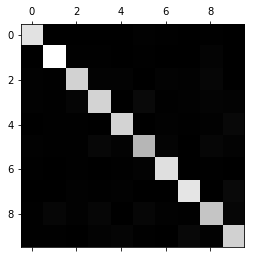

In [40]:
plt.matshow(conf_mx, cmap=plt.cm.gray)
plt.show()

This looks fairly good! Let's focus the plot on the errors though. First, divide each value in the confusion matrix by the number of images in the corresponding class so you can compare error rates instead of absolute number of errors (This would make abundant classes look unfairly bad).

In [41]:
row_sums = conf_mx.sum(axis=1, keepdims=True)
norm_conf_mx = conf_mx / row_sums

Now let's fill the diagonals with zeros to keep only the errors and plot the result!

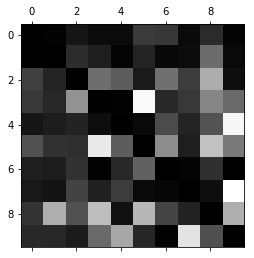

In [42]:
np.fill_diagonal(norm_conf_mx, 0)
plt.matshow(norm_conf_mx, cmap=plt.cm.gray)
plt.show()

Now you can clearly see the errors! Remember, the **rows represent acutal classes** while the **columns represent predicted classes**. Do not that errors are not symetrical, look at 8-5 and 5-8. Analyzing this is a good way to find errors. One way to improve classification, in this case, is to preprocess image data! But enough!!! Let' plot examples of 3s and 5s!

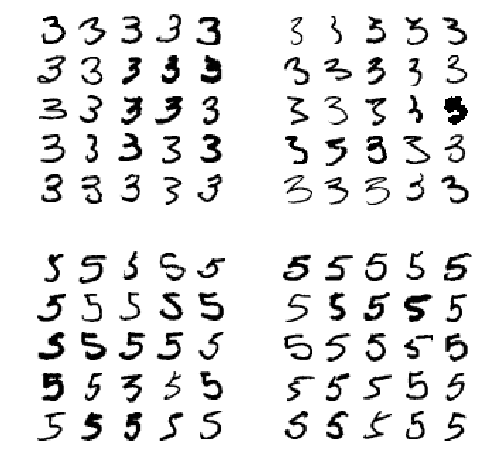

In [43]:
cl_a, cl_b = 3, 5
X_aa = X_train[(y_train == cl_a) & (y_train_pred == cl_a)]
X_ab = X_train[(y_train == cl_a) & (y_train_pred == cl_b)]
X_ba = X_train[(y_train == cl_b) & (y_train_pred == cl_a)]
X_bb = X_train[(y_train == cl_b) & (y_train_pred == cl_b)]

def plot_digits(instances, images_per_row=10, **options):
    size = 28
    images_per_row = min(len(instances), images_per_row)
    images = [instance.reshape(size,size) for instance in instances]
    n_rows = (len(instances) - 1) // images_per_row + 1
    row_images = []
    n_empty = n_rows * images_per_row - len(instances)
    images.append(np.zeros((size, size * n_empty)))
    for row in range(n_rows):
        rimages = images[row * images_per_row : (row + 1) * images_per_row]
        row_images.append(np.concatenate(rimages, axis=1))
    image = np.concatenate(row_images, axis=0)
    plt.imshow(image, cmap = matplotlib.cm.binary, **options)
    plt.axis("off")

plt.figure(figsize=(8, 8))
plt.subplot(221); plot_digits(X_aa[:25], images_per_row=5)
plt.subplot(222); plot_digits(X_ab[:25], images_per_row=5)
plt.subplot(223); plot_digits(X_ba[:25], images_per_row=5)
plt.subplot(224); plot_digits(X_bb[:25], images_per_row=5)
plt.show()

This shows what got confused with what, things classifed as 3's on the left side, things classified as 5's on the right. The errors are cause by using a simple linear classifier! This classifier is quite sensitive to image shifiting and rotation.

## Mulitlabel Classification
If our output is like [1, 0, 1] or "Alice yes, Bob no, Bill yes" then it's a _mulitilabel classification_ system.
We won't go into detail yet, but here's a brief example!

In [46]:
from sklearn.neighbors import KNeighborsClassifier

y_train_large = (y_train >= 7)
y_train_odd = (y_train % 2 == 1)
y_multilabel = np.c_[y_train_large, y_train_odd]

knn_clf = KNeighborsClassifier()
knn_clf.fit(X_train, y_multilabel)

KNeighborsClassifier(algorithm='auto', leaf_size=30, metric='minkowski',
           metric_params=None, n_jobs=1, n_neighbors=5, p=2,
           weights='uniform')

The two labels represent whether or not the digits are large (>= 7) and the other is if it's an odd number.

There are many ways to score a multi-label project, for one example, we can measure the F1 scorefor each individual label, then compute the average score, just like the following.

In [ ]:
y_train_knn_pred = cross_val_predict(knn_clf, X_train, y_train, cv=3)
f1_score(y_train, y_train_knn_pred, average="macro")

This assumes that all labels are equally important... One simple fix for this is to give each label a weight equal to its support. To do this, simply set average="weighted" in the preceding code. See docs for more options.

## Mulitoutput Classification
This last one is _multioutput-multiclass classification_ (or simply _mulitoutput classification_). It's a generalizatin of the mulit-label problem, being that each label an be mulitclass. To show this, let's build a system that removes noise from images! Let's start by making some noise!

In [ ]:
noise = rnd.randint(0, 100, (len(X_train), 784))
noise = rnd.randint(0, 100, (len(X_test), 784))

X_train_mod = X_train + noise
X_test_mod = X_test + noise

y_train_mod = X_train
y_test_mod = X_test

Let's take a peek at an image from the test set (BAD SNOOPING!!!)

Let's train the classifier to clean this image!

In [ ]:
knn_clf.fit(X_train_mod, y_train_mod)
clean_digit = knn_clf.predict([X_test_mod[some_index]])
plot_digit(clean_digit)